In [1]:
from models.logit.base import get_match_result_data

df, player_mapping, inverse_player_mapping = get_match_result_data()

In [2]:
train_df = df[df['date'] < '2016-01-01'].copy()
val_df = df[
    (df['date'] >= '2016-01-01') &
    (df['date'] < '2017-01-01')
].copy()

In [3]:
from models.logit.base import get_X_y

train_X, train_y = get_X_y(train_df, player_mapping)
val_X, val_y = get_X_y(val_df, player_mapping)

In [ ]:
# Tune prior and weights
import numpy as np
from ml.prior_logit import NonZeroLogit
from models.logit.base import _get_weights
from sklearn.metrics import roc_auc_score


N_ATTEMPTS = 50

hls = np.random.uniform(100, 1460, size=N_ATTEMPTS)
lmbdas = np.exp(np.random.uniform(-3, 3, size=N_ATTEMPTS))
priors = np.random.uniform(-5., 0., size=N_ATTEMPTS)

perfs = []
for hl, lmbda, prior in zip(hls, lmbdas, priors):
    print (hl, lmbda, prior)
    weights = _get_weights(train_df['date'].max(), train_df, halflife=hl)
    nzl = NonZeroLogit(lmbda=lmbda, prior=prior)
    nzl.fit(train_X, train_y, sample_weight=weights)
    val_preds = nzl.predict_proba(val_X)[:, 1]
    auc = roc_auc_score(val_df['y'], val_preds)
    accuracy = (val_df['y'] == (val_preds > 0.5).astype(int)).mean()
    perfs.append((hl, lmbda, prior, auc, accuracy))

In [ ]:
import pandas as pd

perf_df = pd.DataFrame(
    perfs,
    columns=[
        'hl',
        'lambda',
        'prior',
        'auc',
        'accuracy'
    ]
)

In [ ]:
perf_df.sort('auc', ascending=False)

#### Use Final Model

In [4]:
from ml.prior_logit import NonZeroLogit
from models.logit.base import _get_weights
from sklearn.metrics import roc_auc_score

nzl = NonZeroLogit(lmbda=2., prior=-2.)
weights = _get_weights(train_df['date'].max(), train_df, halflife=365.)

In [5]:
nzl.fit(train_X, train_y, sample_weight=weights)

In [6]:
preds = nzl.predict_proba(val_X)[:, 1]

In [7]:
from sklearn.isotonic import IsotonicRegression

val_df['pred'] = preds
train_df['pred'] = nzl.predict_proba(train_X)[:, 1]

In [8]:
iso = IsotonicRegression()
iso.fit(train_df['pred'], train_df['y'])

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=None,
          y_min=None)

In [9]:
val_df['cal_pred'] = iso.predict(val_df['pred'])

In [10]:
from sklearn.metrics import roc_auc_score

roc_auc_score(val_df['y'], val_df['pred'])

0.72293202435762416

In [11]:
accuracy = (val_df['y'] == (val_df['cal_pred'] > 0.5)).mean()
accuracy

0.6633663366336634

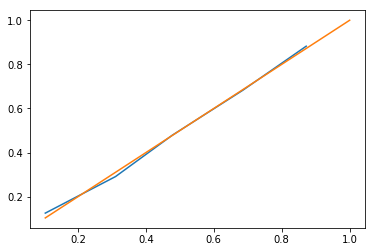

In [12]:
%matplotlib inline
from sklearn.calibration import calibration_curve
from matplotlib import pyplot as plt

_x, _y = calibration_curve(val_df['y'], val_df['cal_pred'])
plt.plot(_x, _y)
plt.plot(_x, _x)

#### Evaluate Betting Performance 

In [13]:
def evaluate_betting(val_df, buff=0):
    val_df['bet1'] = (1. / val_df['p1_odds']) < (val_df['cal_pred'] - buff)
    val_df['bet2'] = (1. / val_df['p2_odds']) < (1. - val_df['cal_pred'] - buff)
    bet_revenues = (
        val_df['p1_odds'] * val_df['bet1'] * val_df['y']  +
        val_df['p2_odds'] * val_df['bet2'] * (1. - val_df['y'])
    )
    bet_spending = val_df['bet1'] + val_df['bet2']
    profit_over_time = bet_revenues.cumsum() - bet_spending.cumsum()
    
    total_placed = bet_spending.sum()
    total_won = (val_df['bet1'] * val_df['y']).sum() + (val_df['bet2'] * (1. - val_df['y'])).sum()
    return bet_revenues.sum() - bet_spending.sum(), profit_over_time 

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/pandas/computation/expressions.py:182: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


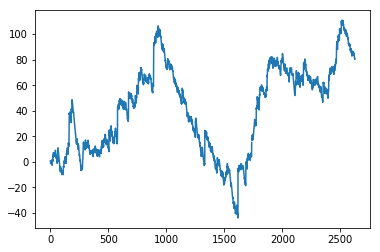

In [14]:
units_won, over_time = evaluate_betting(val_df)
plt.plot(over_time)

In [15]:
units_won

80.220000000000255

#### Compare to always betting on player 1

Let's make sure we lose money if we just choose a random player

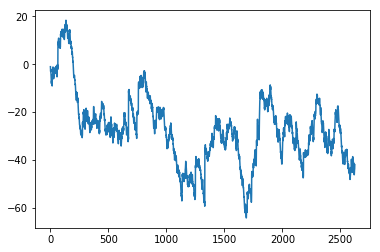

In [21]:
new_val_df = val_df.copy()
new_val_df['cal_pred'] = 0.

units_won, over_time = evaluate_betting(new_val_df)
plt.plot(over_time)

Cool, we lose a ton of money by randomly choosing a player

In [25]:
import numpy as np

val_df['tot_probs'] = ((1 / val_df['p1_odds']) + (1. / val_df['p2_odds']))

In [29]:
val_df[['p1_odds', 'p2_odds', 'winner', 'loser', 'maxw', 'maxl', 'tot_probs']][val_df['tot_probs'] < 1.]

,p1_odds,p2_odds,winner,loser,maxw,maxl,tot_probs
0,1.76,2.35,Dimitrov G.,Simon G.,1.76,2.35,0.993714
3,2.10,1.93,Chung H.,Groth S.,1.93,2.10,0.994325
5,2.38,1.74,Troicki V.,Johnson S.,2.38,1.74,0.994881
11,1.25,5.25,Tomic B.,Mahut N.,1.25,5.25,0.990476
13,1.24,5.85,Nishikori K.,Kukushkin M.,1.24,5.85,0.977392
15,1.37,3.75,Tomic B.,Stepanek R.,1.37,3.75,0.996594
18,1.38,3.70,Dimitrov G.,Troicki V.,1.38,3.70,0.994908
20,1.22,5.84,Raonic M.,Pouille L.,1.22,5.84,0.990905
23,1.23,5.65,Federer R.,Dimitrov G.,1.23,5.65,0.989999
24,1.57,2.92,Raonic M.,Tomic B.,1.57,2.92,0.979408
